## Library

In [1]:
import pandas as pd
import numpy as np
import preprocess_kgptalkie as ps
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import pickle

## Pembersihan Dataset

In [16]:
#buka dataset yang diperlukan
df = pd.read_csv('twitter.csv', header=None, index_col=0)
df = df[[2,3]].reset_index(drop=True)
df.columns = ['sentiment', 'text']
df.head()

,sentiment,text
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


In [18]:
#hapus na value
df.dropna(inplace=True)
df.isnull().sum()

sentiment    0
text         0
dtype: int64

In [19]:
#filter data yang text mengandung kurang dari 6 kata
df = df[df['text'].apply(len)>5]

In [20]:
#cek jumlah sentiment
df['sentiment'].value_counts()

Negative      22020
Positive      20186
Neutral       17898
Irrelevant    12778
Name: sentiment, dtype: int64

## Preprocessing Data I

Preprocessing data ini menggunakan Preprocessing Text Python Package dari [github](https://github.com/laxmimerit/preprocess_kgptalkie) milik laxmimerit.

In [21]:
#menghitung jumlah karakter, jumlah kata, rerata panjang kata,
#jumlah stopwords, jumlah hashtag, jumlah mention, 
#jumlah digit, dan jumlah huruf besar
df = ps.get_basic_features(df)

In [11]:
df.head()

,sentiment,text,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,Positive,im getting on borderlands and i will murder yo...,43,11,3.909091,6,0,0,1,0
1,Positive,I am coming to the borders and I will kill you...,40,12,3.333333,6,0,0,1,2
2,Positive,im getting on borderlands and i will kill you ...,41,10,4.100000,5,0,0,1,0
3,Positive,im coming on borderlands and i will murder you...,42,10,4.200000,5,0,0,1,0
4,Positive,im getting on borderlands 2 and i will murder ...,46,12,3.833333,6,0,0,2,0


In [7]:
#manipulasi text untuk model machine learning
df['text'] = df['text'].apply(lambda x: x.lower())
df['text'] = df['text'].apply(lambda x: ps.remove_urls(x))
df['text'] = df['text'].apply(lambda x: ps.remove_html_tags(x))
df['text'] = df['text'].apply(lambda x: ps.remove_rt(x))
df['text'] = df['text'].apply(lambda x: ps.remove_special_chars(x))

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\preprocess_kgptalkie\utils.py:97: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(x, 'lxml').get_text().strip()


## Plot Data

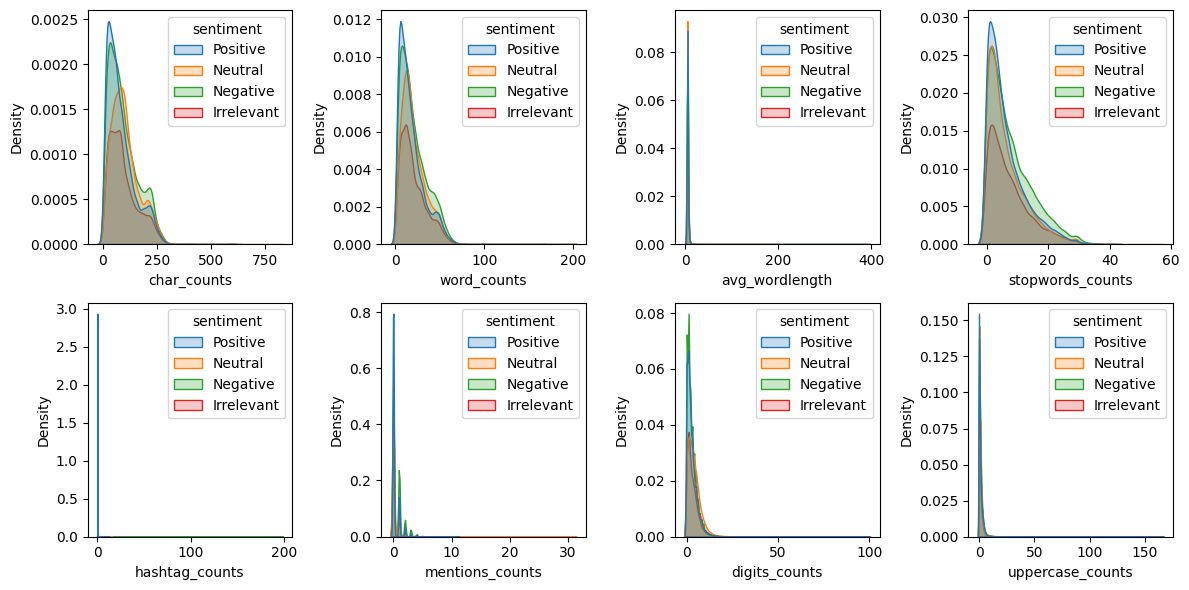

In [8]:
#plot kde antara sentimen dengan berbagai parameter
plt.figure(figsize=(12,6))

num_cols = df.select_dtypes(include='number').columns
for index, col in enumerate(num_cols):
    plt.subplot(2,4,index+1)
    sns.kdeplot(data=df, x=col, hue='sentiment', fill=True)

plt.tight_layout()
plt.show()


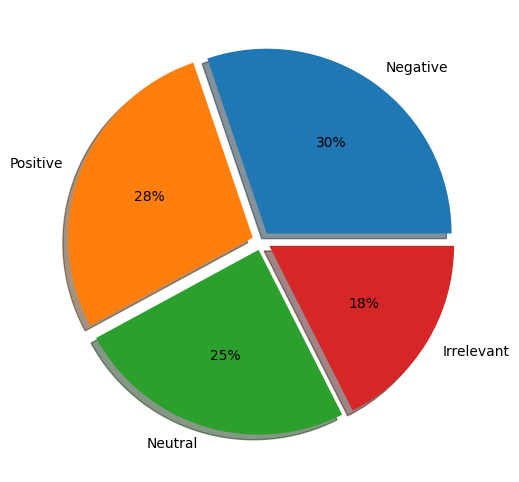

In [9]:
#plot piechart jumlah text tiap 
plt.figure(figsize=(12,6))
plt.pie(df['sentiment'].value_counts(), labels=df['sentiment'].value_counts().index,
        autopct='%1.0f%%', explode=(0.05,0.05,0.05,0.05), shadow=True)
plt.show()

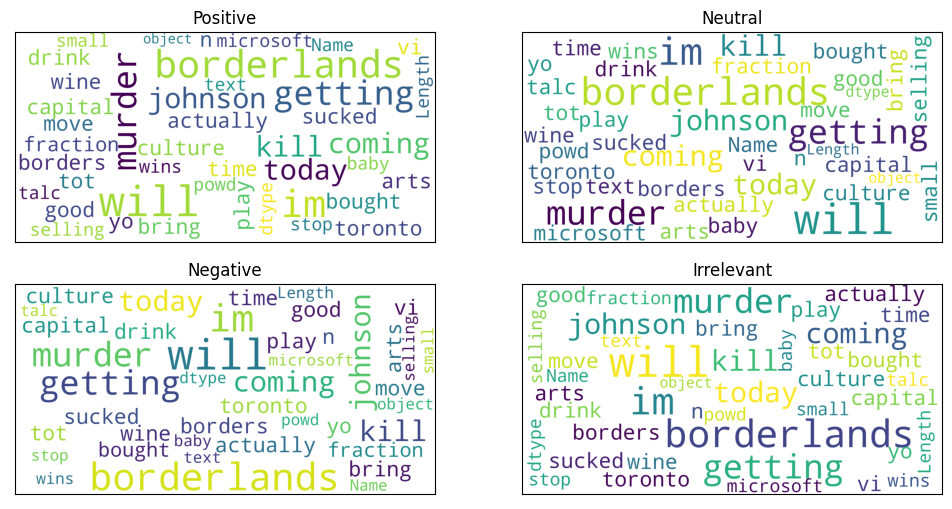

In [10]:
#plot wordcloud jumlah kata dari tiap sentiment
stopwords = set(STOPWORDS)
plt.figure(figsize=(12,6))

for index, sent in enumerate(df.sentiment.unique()):
    plt.subplot(2,2,index+1)
    data = df[df['sentiment']==sent]['text']
    wordcloud = WordCloud(background_color='white', stopwords=stopwords,
                          max_words=300, max_font_size=40, scale=5).generate(str(df['text']))
    plt.imshow(wordcloud)
    plt.xticks([])
    plt.yticks([])
    plt.title(sent)

## Random Forest Machine Learning

In [11]:
#persiapan data train dan data test
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'],
                                                    test_size=0.2,
                                                    random_state=0)

In [13]:
clf = Pipeline([('tfid',TfidfVectorizer()),
                ('rfc',RandomForestClassifier(n_jobs=-1))])

clf.fit(X_train, y_train)

Pipeline(steps=[('tfid', TfidfVectorizer()),
                ('rfc', RandomForestClassifier(n_jobs=-1))])

In [16]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  Irrelevant       0.97      0.86      0.91      2503
    Negative       0.91      0.95      0.93      4535
     Neutral       0.93      0.92      0.92      3587
    Positive       0.91      0.94      0.92      3952

    accuracy                           0.92     14577
   macro avg       0.93      0.92      0.92     14577
weighted avg       0.93      0.92      0.92     14577



In [18]:
pickle.dump(clf, open('twitter.pkl','wb'))